In [422]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from scipy.stats import norm
from sklearn.metrics import r2_score

In [423]:
# Laste poll-of-polls data
df = pd.read_csv("../data/v2_data_august.csv", sep=",")

In [424]:
df

,Mnd,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,...,Rodt_reg_lag3,Rodt_reg_lag6,Andre_reg_lag3,Andre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
0,1/31/2008,29.3,17.2,23.9,7.4,6.1,6.4,6.5,0.0,1.3,...,NaN,NaN,NaN,NaN,2.6,NaN,NaN,5.25,NaN,NaN
1,2/29/2008,29.0,17.3,25.2,6.7,5.9,6.3,6.6,0.0,1.3,...,NaN,NaN,NaN,NaN,2.6,NaN,NaN,5.25,NaN,NaN
2,3/31/2008,28.7,18.1,25.2,7.0,5.6,6.1,6.3,0.0,1.1,...,0.0,NaN,0.0,NaN,2.6,0.000,NaN,5.25,0.000000,NaN
3,4/30/2008,29.0,16.9,25.4,6.5,5.5,7.0,6.8,0.0,1.2,...,0.0,NaN,0.0,NaN,2.7,0.033,NaN,5.31,0.020000,NaN
4,5/31/2008,28.9,17.8,25.9,6.7,5.7,6.2,6.2,0.0,1.4,...,0.0,NaN,0.0,NaN,2.8,0.067,NaN,5.50,0.083333,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,5/31/2025,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
209,6/30/2025,28.3,16.2,21.0,6.9,5.6,3.7,4.5,3.0,6.2,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
210,7/31/2025,27.7,14.8,21.5,8.2,6.3,3.2,4.7,3.5,5.9,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.25,-0.083333,-0.041667
211,8/31/2025,27.3,15.3,21.2,6.3,6.2,4.6,4.2,4.3,6.1,...,0.0,0.0,0.0,0.0,4.0,0.000,0.000000,4.25,-0.083333,-0.041667


In [425]:
ex_future=df[df['Ap'].isna()][['Mnd',
       'Ap_skandale_lag6', 'Hoyre_skandale_lag6', 'Frp_skandale_lag6',
       'SV_skandale_lag6', 'SP_skandale_lag6', 'KrF_skandale_lag6',
        'Rodt_skandale_lag6',
        'Ap_reg_lag6',
        'Hoyre_reg_lag6', 
        #'Frp_reg_lag6','SV_reg_lag6', 
        #'SP_reg_lag6','KrF_reg_lag6',
        #'Venstre_reg_lag6', 
       'ledighet', 'ledig_trend3', 'ledig_trend6', 'styringsrente',
       'styringsrente_trend3', 'styringsrente_trend6']]

In [426]:
ex_future
ex_future["Mnd"] = pd.to_datetime(df["Mnd"])
ex_future.set_index("Mnd", inplace=True)

In [427]:
df.dropna(inplace=True)

In [428]:
df

,Mnd,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,...,Rodt_reg_lag3,Rodt_reg_lag6,Andre_reg_lag3,Andre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
5,6/30/2008,26.0,17.6,28.9,6.9,5.3,6.1,5.9,0.0,1.8,...,0.0,0.0,0.0,0.0,2.9,0.067,0.050000,5.54,0.076667,0.048333
6,7/31/2008,26.9,17.2,30.2,6.6,4.7,6.1,5.4,0.0,1.9,...,0.0,0.0,0.0,0.0,2.9,0.033,0.050000,5.75,0.083333,0.083333
7,8/31/2008,26.6,16.2,30.9,6.7,5.2,5.5,6.0,0.0,1.7,...,0.0,0.0,0.0,0.0,3.0,0.033,0.066667,5.75,0.070000,0.083333
8,9/30/2008,28.9,15.2,29.9,6.3,5.0,5.7,5.9,0.0,1.5,...,0.0,0.0,0.0,0.0,3.1,0.067,0.066667,5.75,0.000000,0.073333
9,10/31/2008,30.6,16.1,26.7,7.3,5.3,5.6,5.5,0.0,1.2,...,0.0,0.0,0.0,0.0,3.1,0.033,0.050000,5.45,-0.100000,-0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,4/30/2025,28.1,19.8,20.0,6.3,6.7,3.3,3.9,3.1,4.8,...,0.0,0.0,0.0,0.0,4.0,-0.033,-0.016667,4.50,0.000000,0.000000
208,5/31/2025,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
209,6/30/2025,28.3,16.2,21.0,6.9,5.6,3.7,4.5,3.0,6.2,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
210,7/31/2025,27.7,14.8,21.5,8.2,6.3,3.2,4.7,3.5,5.9,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.25,-0.083333,-0.041667


In [429]:
# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"])

In [430]:
# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

In [431]:
df

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre,...,Rodt_reg_lag3,Rodt_reg_lag6,Andre_reg_lag3,Andre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
Mnd,,,,,,,,,,,,,,,,,,,,,
2008-06-30,26.0,17.6,28.9,6.9,5.3,6.1,5.9,0.0,1.8,0.0,...,0.0,0.0,0.0,0.0,2.9,0.067,0.050000,5.54,0.076667,0.048333
2008-07-31,26.9,17.2,30.2,6.6,4.7,6.1,5.4,0.0,1.9,0.0,...,0.0,0.0,0.0,0.0,2.9,0.033,0.050000,5.75,0.083333,0.083333
2008-08-31,26.6,16.2,30.9,6.7,5.2,5.5,6.0,0.0,1.7,0.0,...,0.0,0.0,0.0,0.0,3.0,0.033,0.066667,5.75,0.070000,0.083333
2008-09-30,28.9,15.2,29.9,6.3,5.0,5.7,5.9,0.0,1.5,0.0,...,0.0,0.0,0.0,0.0,3.1,0.067,0.066667,5.75,0.000000,0.073333
2008-10-31,30.6,16.1,26.7,7.3,5.3,5.6,5.5,0.0,1.2,0.0,...,0.0,0.0,0.0,0.0,3.1,0.033,0.050000,5.45,-0.100000,-0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-30,28.1,19.8,20.0,6.3,6.7,3.3,3.9,3.1,4.8,3.9,...,0.0,0.0,0.0,0.0,4.0,-0.033,-0.016667,4.50,0.000000,0.000000
2025-05-31,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3,3.8,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
2025-06-30,28.3,16.2,21.0,6.9,5.6,3.7,4.5,3.0,6.2,4.5,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000


In [432]:
df_en=df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
df_en = df_en.diff().dropna()  # Difference to make stationary
df_orig=df

In [433]:
df_ex=df[[
       'Ap_skandale_lag6', 'Hoyre_skandale_lag6', 'Frp_skandale_lag6',
       'SV_skandale_lag6', 'SP_skandale_lag6', 'KrF_skandale_lag6',
       #'Venstre_skandale_lag6', 
        #'MDG_skandale_lag6', 
       'Rodt_skandale_lag6',
       #'Andre_skandale_lag6', 
       # 'Ap_reg', 'Hoyre_reg', 'Frp_reg', 'SV_reg',
       #'SP_reg', 'KrF_reg', 'Venstre_reg', 'MDG_reg', 'Rodt_reg', 'Andre_reg',
       #'Ap_reg_lag3', 
       'Ap_reg_lag6',
        'Hoyre_reg_lag6', 
       # 'Frp_reg_lag6','SV_reg_lag6', 
       # 'SP_reg_lag6','KrF_reg_lag6',
       # 'Venstre_reg_lag6', 
        #'MDG_reg_lag6',
        #'Rodt_reg_lag6', 
        #'Andre_reg_lag6',
       'ledighet', 'ledig_trend3', 'ledig_trend6', 'styringsrente',
       'styringsrente_trend3', 'styringsrente_trend6']].iloc[1:]

In [434]:
df_ex

,Ap_skandale_lag6,Hoyre_skandale_lag6,Frp_skandale_lag6,SV_skandale_lag6,SP_skandale_lag6,KrF_skandale_lag6,Rodt_skandale_lag6,Ap_reg_lag6,Hoyre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
Mnd,,,,,,,,,,,,,,,
2008-07-31,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,2.9,0.033,0.050000,5.75,0.083333,0.083333
2008-08-31,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.0,0.033,0.066667,5.75,0.070000,0.083333
2008-09-30,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.1,0.067,0.066667,5.75,0.000000,0.073333
2008-10-31,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.1,0.033,0.050000,5.45,-0.100000,-0.008333
2008-11-30,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.1,0.000,0.033333,4.75,-0.333333,-0.131667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,4.0,-0.033,-0.016667,4.50,0.000000,0.000000
2025-05-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
2025-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000


In [435]:
#model = VARMAX(endog=df_en, exog=df_ex, order=(6,0), trend='c')
#model_fitted = model.fit(disp=False)

#print(model_fitted.summary())

In [436]:
model = VAR(endog=df_en, exog=df_ex)
#model = VAR(endog=df_en)

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [437]:
model_fitted = model.fit(maxlags=3,method = 'ols', trend='n', verbose=True)
print(model_fitted.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 04, Sep, 2025
Time:                     09:25:10
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -5.12760
Nobs:                     203.000    HQIC:                  -9.50084
Log likelihood:          -1164.52    FPE:                4.12969e-06
AIC:                     -12.4721    Det(Omega_mle):     5.57649e-07
--------------------------------------------------------------------
Results for equation Ap
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
Ap_skandale_lag6            -0.108297         0.241698           -0.448           0.654
Hoyre_skandale_lag6          0.039364         0.253611            0.155           0.877
Frp_skandale_lag6            0.1032

In [438]:
# Compute R² for each party
r2_scores = {}
for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']:
    r2_scores[party] = r2_score(df_en[party].iloc[model_fitted.k_ar:], model_fitted.fittedvalues[party])

# Print R² values
for party, r2 in r2_scores.items():
    print(f"R² for {party}: {r2:.4f}")

R² for Ap: 0.2417
R² for Hoyre: 0.3195
R² for Frp: 0.2814
R² for SV: 0.3435
R² for SP: 0.2519
R² for KrF: 0.4625
R² for Venstre: 0.3247
R² for MDG: 0.2636
R² for Rodt: 0.3539
R² for Andre: 0.3217


In [439]:
# Check if the VAR model is stable (roots inside the unit circle)
print("Is the VAR model stable?", model_fitted.is_stable())

Is the VAR model stable? True


In [440]:
all_fitted= model_fitted.fittedvalues

In [441]:
all_fitted

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre
Mnd,,,,,,,,,,
2008-10-31,0.148058,0.198069,-0.409937,0.523578,-0.192693,0.194419,-0.051058,0.035196,-0.251238,-0.175400
2008-11-30,0.943373,0.024416,-0.435126,-0.044476,-0.598892,0.492403,0.085633,-0.182515,-0.300683,-0.044722
2008-12-31,0.276821,0.902727,-0.031770,-0.120906,-0.101838,-0.513493,-0.276211,-0.010403,-0.262488,-0.320074
2009-01-31,2.402126,-1.717862,-0.868461,-0.151993,0.059008,-0.049548,0.232280,0.023789,-0.029579,-0.128349
2009-02-28,1.053632,-0.704256,-0.410424,-0.284716,-0.076869,-0.060666,0.486981,0.131229,0.052521,-0.103712
...,...,...,...,...,...,...,...,...,...,...
2025-04-30,-0.647178,0.123871,-0.493733,-0.207728,0.591685,0.339359,0.094211,0.256809,0.103624,0.012150
2025-05-31,0.315016,-0.756380,0.044292,0.631131,-0.182988,0.059482,0.025122,-0.237416,0.278852,-0.038706
2025-06-30,1.042796,-1.321102,0.425658,-0.569188,0.434393,-0.071543,-0.159837,0.391952,-0.200199,-0.067390


In [442]:
steps = 1  # Number of steps to forecast
alpha = 0.1

forecast, lower, upper = model_fitted.forecast_interval(df_en.values[-model_fitted.k_ar:],  exog_future=ex_future, steps=steps, alpha=alpha)


In [443]:
forecast

array([[-0.30333737, -0.18571784,  0.44090763,  0.63317091,  0.69009562,
        -0.88675065,  0.27567106, -0.15130579,  0.27802659, -0.87739951]])

In [444]:
forecast_dates = pd.date_range(start="2025-09-30", periods=steps, freq='ME')

last_actual_value = df_orig.iloc[-1]  # Last known actual data point

forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=df_en.columns)
forecast_lower_df=pd.DataFrame(lower, index=forecast_dates, columns=df_en.columns)
forecast_upper_df=pd.DataFrame(upper, index=forecast_dates, columns=df_en.columns)

forecast_df = forecast_df.cumsum() + last_actual_value
forecast_lower_df = forecast_lower_df.cumsum() + last_actual_value
forecast_upper_df = forecast_upper_df.cumsum() + last_actual_value

In [445]:
# Get forecast covariance in differenced scale
forecast_cov = model_fitted.forecast_cov(steps=steps)

# Cumulative sum of covariance matrices to restore original scale
for t in range(steps):
    forecast_cov[t] = np.sum(forecast_cov[:t+1], axis=0)

# Convert to DataFrames for readability
forecast_cov_df = {t: pd.DataFrame(forecast_cov[t], index=df_en.columns, columns=df_en.columns)
                            for t in range(steps)}

In [446]:
df_en=df_orig

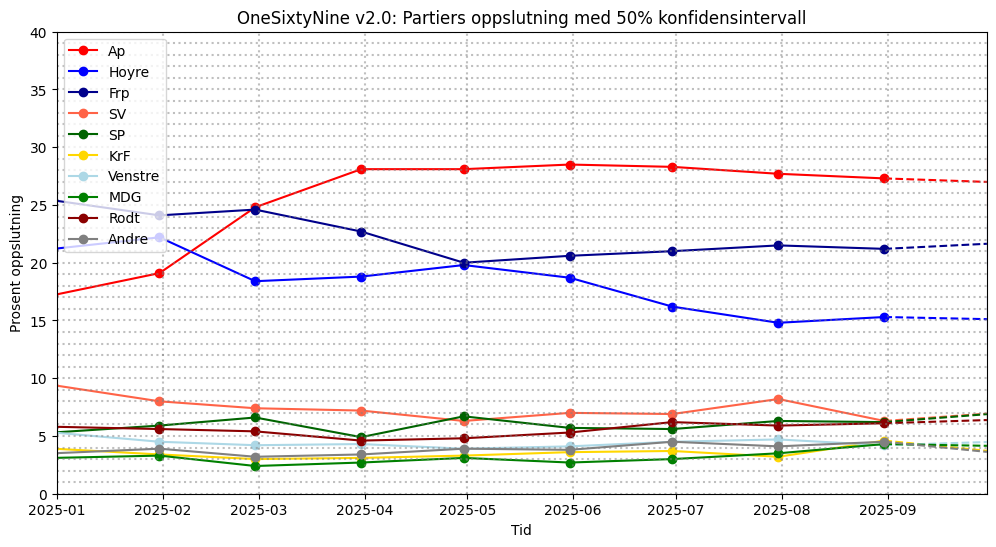

In [447]:
# Define a color map for consistency
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
    'Frp': '#00008B',       # Dark Blue
    'SV': '#FF6347',        # Light Red (Tomato)
    'SP': '#006400',        # Dark Green
    'KrF': '#FFD700',       # Yellow (Gold)
    'Venstre': '#ADD8E6',   # Light Blue
    'MDG': '#008000',       # Green
    'Rodt': '#8B0000',      # Dark Red
    'Andre': '#808080'      # Gray
}

plt.figure(figsize=(12, 6))

for party in colors.keys():  # Iterate over defined parties
    color = colors[party]  

    # Plot actual data
    plt.plot(df_en.index, df_en[party], marker="o", color=color, label=f"{party}")

    # Plot forecast 
    plt.plot(forecast_df.index, forecast_df[party], linestyle="dashed", color=color)

    last_actual_date = df_en.index[-1]
    first_forecast_date = forecast_df.index[0]
    last_actual_value = df_en[party].iloc[-1]
    first_forecast_value = forecast_df[party].iloc[0]

    plt.plot([last_actual_date, first_forecast_date], [last_actual_value, first_forecast_value], color=color, linestyle="dashed")
    
    # Plot confidence interval (original scale)
    plt.fill_between(forecast_df.index, 
                     forecast_lower_df[party], 
                     forecast_upper_df[party], 
                     color=color, alpha=0.2)


dates = pd.date_range(start="2023-01-01", end="2025-09-30", freq="MS") 
for date in dates:
    plt.axvline(date, color="gray", linestyle="dotted", alpha=0.5)

# Add horizontal grid lines every 5%
for percent in range(0, 45, 1):
    plt.axhline(percent, color="gray", linestyle="dotted", alpha=0.5)

plt.xlim(np.datetime64("2025-01-01"), np.datetime64("2025-09-30"))  # Manually set max date to Sept 2025
plt.ylim(0,40)  # Manually set max date to Sept 2025
plt.xlabel("Tid")
plt.ylabel("Prosent oppslutning")
plt.title("OneSixtyNine v2.0: Partiers oppslutning med 50% konfidensintervall")
plt.legend(loc="upper left")
plt.show()

In [448]:
forecast_df=forecast_df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
#forecast_df=(forecast_df.T / forecast_df.sum(axis=1) * 100).T
forecast_lower_df=forecast_lower_df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
forecast_upper_df=forecast_upper_df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]

In [449]:
###finn estimat for september
date_to_extract = "2025-09-30"

# Extract the row for the given date from each dataframe
estimate_row = forecast_df.loc[date_to_extract]
lower_row = forecast_lower_df.loc[date_to_extract]
upper_row = forecast_upper_df.loc[date_to_extract]

# Combine into a new DataFrame
result_df = pd.DataFrame({
    "Party": estimate_row.index,
    "Estimate": estimate_row.values,
    "Lower": lower_row.values,
    "Upper": upper_row.values
})

# Display the final structured DataFrame
result_df

,Party,Estimate,Lower,Upper
0,Ap,26.996663,24.608210,29.385115
1,Hoyre,15.114282,13.147250,17.081314
2,Frp,21.640908,19.804081,23.477734
3,SV,6.933171,6.192214,7.674128
4,SP,6.890096,5.432626,8.347566
5,KrF,3.713249,3.162576,4.263923
6,Venstre,4.475671,3.813874,5.137468
7,MDG,4.148694,3.582974,4.714415
8,Rodt,6.378027,5.662634,7.093419
9,Andre,3.622600,3.008102,4.237099


In [450]:
# Multivariate MC!
n_sim = 100000
# Extract mean estimates (yhat) and covariance matrix
yhat_vector = result_df["Estimate"].values  # Mean estimates for all parties
#yhat_vector = df_orig.iloc[-1][['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt','Andre']].values
cov_matrix = forecast_cov[-1]  # Covariance matrix at final step (latest forecast)
#cov_matrix_df = df_orig[['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt','Andre']].cov()#.to_numpy()
#cov_matrix=cov_matrix_df.to_numpy()

# Convert to NumPy array
#W = cov_matrix.to_numpy()

# Generate correlated samples
samples = np.random.multivariate_normal(yhat_vector, cov_matrix, size=n_sim)
samples = np.maximum(samples, 1e-6) ##must be above 0
samples = (samples.T / samples.sum(axis=1) * 100).T

# Create a DataFrame with sampled values
sampled_df = pd.DataFrame(samples, columns=result_df["Party"])

# Compute vote totals for each simulation
red_green_votes = sampled_df[["Ap", "SV", "SP", "Rodt", "MDG"]].sum(axis=1)# /sampled_df.sum(axis=1)
blue_votes = sampled_df[["Hoyre", "Frp", "KrF", "Venstre"]].sum(axis=1)# /sampled_df.sum(axis=1)

# Probability that red-green block wins
prob_red_green_wins = np.mean(red_green_votes > blue_votes)

print(f"Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: {prob_red_green_wins:.4f}")


Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: 0.9868


In [451]:
yhat_vector

array([26.99666263, 15.11428216, 21.64090763,  6.93317091,  6.89009562,
        3.71324935,  4.47567106,  4.14869421,  6.37802659,  3.62260049])

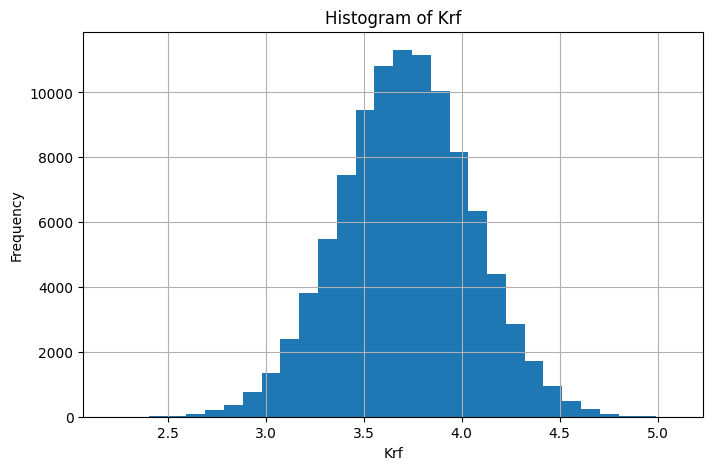

In [452]:
sampled_df[['KrF']].hist(bins=30, figsize=(8, 5))
plt.xlabel('Krf')
plt.ylabel('Frequency')
plt.title('Histogram of Krf')
plt.show()

In [453]:
yhat_vector

array([26.99666263, 15.11428216, 21.64090763,  6.93317091,  6.89009562,
        3.71324935,  4.47567106,  4.14869421,  6.37802659,  3.62260049])

In [454]:
df_orig.iloc[-1][['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt','Andre']].values

array([27.3, 15.3, 21.2,  6.3,  6.2,  4.6,  4.2,  4.3,  6.1,  4.5])

In [455]:
df_orig_p=df_orig[['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt']]

In [456]:
df_orig_p

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt
Mnd,,,,,,,,,
2008-06-30,26.0,17.6,28.9,6.9,5.3,6.1,5.9,0.0,1.8
2008-07-31,26.9,17.2,30.2,6.6,4.7,6.1,5.4,0.0,1.9
2008-08-31,26.6,16.2,30.9,6.7,5.2,5.5,6.0,0.0,1.7
2008-09-30,28.9,15.2,29.9,6.3,5.0,5.7,5.9,0.0,1.5
2008-10-31,30.6,16.1,26.7,7.3,5.3,5.6,5.5,0.0,1.2
...,...,...,...,...,...,...,...,...,...
2025-04-30,28.1,19.8,20.0,6.3,6.7,3.3,3.9,3.1,4.8
2025-05-31,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3
2025-06-30,28.3,16.2,21.0,6.9,5.6,3.7,4.5,3.0,6.2


In [457]:
sampled_df.drop(columns=["Andre"], inplace=True)

In [458]:
yhat_vector

array([26.99666263, 15.11428216, 21.64090763,  6.93317091,  6.89009562,
        3.71324935,  4.47567106,  4.14869421,  6.37802659,  3.62260049])

In [459]:
orig_mandate=pd.DataFrame(columns=df_orig.columns)

In [460]:
sample_mandate=pd.DataFrame(columns=sampled_df.columns)

In [461]:
def calc_mandat(oppslutt):
    if oppslutt <4.0:
        mandat=np.round(1/4*oppslutt**2,0)
    else: 
        oppslutt=round(1.8119*oppslutt,0)
    return int(oppslutt)

In [462]:
for party in sampled_df.columns:
    sample_mandate[party]=sampled_df[party].apply(calc_mandat)

In [463]:
for party in df_orig[['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt']]:
    orig_mandate[party]=df_orig[party].apply(calc_mandat)

In [464]:
orig_mandate

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre,...,Rodt_reg_lag3,Rodt_reg_lag6,Andre_reg_lag3,Andre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
Mnd,,,,,,,,,,,,,,,,,,,,,
2008-06-30,47,32,52,13,10,11,11,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-07-31,49,31,55,12,9,11,10,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-31,48,29,56,12,9,10,11,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-09-30,52,28,54,11,9,10,11,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-10-31,55,29,48,13,10,10,10,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-30,51,36,36,11,12,3,3,3,9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-31,52,34,37,13,10,3,7,2,10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-30,51,29,38,13,10,3,8,3,11,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [465]:
sample_mandate

Party,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt
0,49,26,42,13,13,8,8,7,11
1,46,28,37,13,14,3,7,8,12
2,51,27,41,13,12,2,7,3,11
3,43,30,43,13,13,3,8,8,11
4,51,25,37,13,14,3,7,8,12
...,...,...,...,...,...,...,...,...,...
99995,46,33,38,11,12,3,8,3,12
99996,48,26,39,14,13,3,8,8,12
99997,49,26,38,12,13,7,8,7,12
99998,50,29,39,11,11,3,3,8,12


In [466]:
sample_mandate.to_csv('sample_august.csv')

In [467]:
import numpy as np
import pandas as pd

#W = cov_matrix.to_numpy()[:9, :9]  # must be a numpy array
W = cov_matrix[:9, :9]
party_cols = ['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt']
X = sample_mandate[party_cols].to_numpy()
one_vec = np.ones(len(party_cols))
W_inv = np.linalg.inv(W)

target_sum = 169
X_adj = []

for row in X:
    diff = target_sum - row.sum()
    # GLS adjustment (float)
    lambda_ = diff / (one_vec @ W_inv @ one_vec)
    adj_row = row + W_inv @ one_vec * lambda_

    # Convert to integers using largest remainder
    int_row = np.floor(adj_row).astype(int)
    remainder = int_row.sum()
    deficit = target_sum - remainder

    # Distribute remaining seats to largest fractional parts
    frac = adj_row - np.floor(adj_row)
    for i in np.argsort(-frac)[:deficit]:
        int_row[i] += 1

    X_adj.append(int_row)

# Replace with adjusted integer values
df_adj = sample_mandate.copy()
df_adj[party_cols] = X_adj
df_adj['Sum_adj'] = df_adj[party_cols].sum(axis=1)

#print(df_adj[['Sum_adj']].head())


In [468]:
sample_169=df_adj

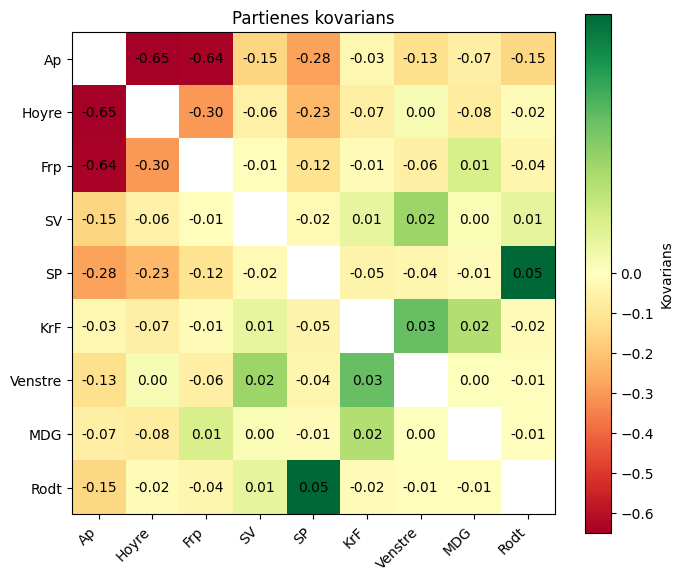

In [469]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Party labels
labels = ['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt']

# Mask diagonal to hide color
W_masked = W.copy()
np.fill_diagonal(W_masked, np.nan)

# Normalize colormap to center at zero
norm = mcolors.TwoSlopeNorm(vmin=np.nanmin(W_masked), vcenter=0, vmax=np.nanmax(W_masked))

plt.figure(figsize=(7, 6))
im = plt.imshow(W_masked, cmap='RdYlGn', norm=norm)
plt.colorbar(im, label='Kovarians')
plt.title('Partienes kovarians')

# Add numerical values for non-diagonal cells
for i in range(W.shape[0]):
    for j in range(W.shape[1]):
        if i != j:
            plt.text(j, i, f"{W[i, j]:.2f}", ha='center', va='center', color='black')

# Set axis ticks and labels
plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(labels)), labels=labels)

plt.grid(False)
plt.tight_layout()
plt.show()


In [470]:
sample_169['rg'] = sample_169[["Ap", "SV", "SP", "Rodt", "MDG"]].sum(axis=1)

In [471]:
sample_169['bb'] = sample_169[["Hoyre", "Frp", "Venstre", "KrF"]].sum(axis=1)

In [472]:
sample_169

Party,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Sum_adj,rg,bb
0,48,25,41,12,13,7,7,6,10,169,89,80
1,46,28,37,13,14,3,7,9,12,169,94,75
2,51,27,41,13,12,2,8,4,11,169,91,78
3,43,30,43,13,13,2,7,7,11,169,87,82
4,51,25,37,13,14,3,7,7,12,169,97,72
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,46,33,38,11,12,4,9,4,12,169,85,84
99996,48,26,39,14,13,3,7,7,12,169,94,75
99997,49,26,38,12,13,6,7,6,12,169,92,77
99998,50,29,39,11,11,4,4,9,12,169,93,76


In [473]:
sample_169['r_win'] = (sample_169['bb'] < sample_169['rg'])

In [474]:
sample_169['r_win'].mean()

0.98444

In [475]:
filtered = sample_169[(sample_169['MDG'] < 4) & (sample_169['KrF'] > 4) & (sample_169['Venstre'] > 4)]

# Calculate probability
prob = filtered['r_win'].mean()

print(f"Probability: {prob:.4f}")
print(f"Number of cases: {len(filtered)}")

Probability: 0.8765
Number of cases: 4476


In [476]:
len(sample_169[sample_169['Rodt'] < 8])

1

In [477]:
sample_169['red_green'] = sample_169[["Ap", "SV", "SP", "Rodt", "MDG"]].sum(axis=1)

In [478]:
sample_169['red_green'] = sample_169[["Ap", "SV", "SP", "Rodt", "MDG"]].sum(axis=1)
sample_169['ap_sp'] = sample_169[["Ap", "SP"]].sum(axis=1)
sample_169['ap_sp_sv'] = sample_169[["Ap", "SP", "SV"]].sum(axis=1)
sample_169['ap_sp_sv_r'] = sample_169[["Ap", "SP", "SV", "Rodt"]].sum(axis=1)
sample_169['ap_sp_sv_r_mdg'] = sample_169[["Ap", "SP", "SV", "Rodt", "MDG"]].sum(axis=1)
sample_169['h_frp'] = sample_169[["Hoyre", "Frp"]].sum(axis=1)
sample_169['h_frp_v_krf'] = sample_169[["Hoyre", "Frp", "Venstre", "KrF"]].sum(axis=1)
sample_169['h_frp_v_krf_mdg'] = sample_169[["Hoyre", "Frp", "Venstre", "KrF", "MDG"]].sum(axis=1)

In [479]:
sample_169['red_green_victory'] = sample_169['red_green'] >= 85
sample_169['ap_sp_victory'] = sample_169['ap_sp'] >= 85
sample_169['ap_sp_sv_victory'] = sample_169['ap_sp_sv'] >= 85
sample_169['ap_sp_sv_r'] = sample_169['ap_sp_sv_r'] >= 85
sample_169['ap_sp_sv_r_mdg'] = sample_169['ap_sp_sv_r_mdg'] >= 85
sample_169['h_frp'] = sample_169['h_frp'] >= 85
sample_169['h_frp_v_krf'] = sample_169['h_frp_v_krf'] >= 85
sample_169['h_frp_v_krf_mdg'] = sample_169['h_frp_v_krf_mdg'] >= 85

In [480]:
sample_169['r_avh'] = (sample_169[["Ap", "SP", "SV"]].sum(axis=1) < 85) & (sample_169[["Ap", "SP", "SV", "Rodt"]].sum(axis=1)) >= 85

In [481]:
sample_169['g_avh'] = (sample_169[["Ap", "SP", "SV", "Rodt"]].sum(axis=1) < 85) & (sample_169[["Ap", "SP", "SV", "Rodt", "MDG"]].sum(axis=1)) >= 85

In [482]:
print(sample_169['red_green_victory'].mean())
print(sample_169['ap_sp_victory'].mean())
print(sample_169['ap_sp_sv_victory'].mean())
print(sample_169['ap_sp_sv_r'].mean())
print(sample_169['ap_sp_sv_r_mdg'].mean())
print(sample_169['h_frp'].mean())
print(sample_169['h_frp_v_krf'].mean())
print(sample_169['h_frp_v_krf_mdg'].mean())
print(sample_169['r_avh'].mean())
print(sample_169['g_avh'].mean())

0.98444
0.0
0.00011
0.614
0.98444
0.0
0.01556
0.386
0.0
0.0


In [483]:
sample_169.to_csv('sample.csv')

In [484]:
len(sample_169['rg'])

100000

In [485]:
np.round(sample_169['rg'])

0        89
1        94
2        91
3        87
4        97
         ..
99995    85
99996    94
99997    92
99998    93
99999    93
Name: rg, Length: 100000, dtype: int64

In [486]:
sample_169

Party,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Sum_adj,...,ap_sp_sv_r,ap_sp_sv_r_mdg,h_frp,h_frp_v_krf,h_frp_v_krf_mdg,red_green_victory,ap_sp_victory,ap_sp_sv_victory,r_avh,g_avh
0,48,25,41,12,13,7,7,6,10,169,...,False,True,False,False,True,True,False,False,False,False
1,46,28,37,13,14,3,7,9,12,169,...,True,True,False,False,False,True,False,False,False,False
2,51,27,41,13,12,2,8,4,11,169,...,True,True,False,False,False,True,False,False,False,False
3,43,30,43,13,13,2,7,7,11,169,...,False,True,False,False,True,True,False,False,False,False
4,51,25,37,13,14,3,7,7,12,169,...,True,True,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,46,33,38,11,12,4,9,4,12,169,...,False,True,False,False,True,True,False,False,False,False
99996,48,26,39,14,13,3,7,7,12,169,...,True,True,False,False,False,True,False,False,False,False
99997,49,26,38,12,13,6,7,6,12,169,...,True,True,False,False,False,True,False,False,False,False
99998,50,29,39,11,11,4,4,9,12,169,...,False,True,False,False,True,True,False,False,False,False


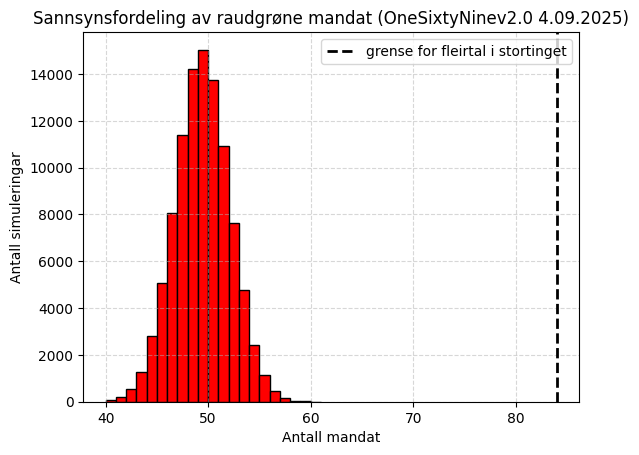

In [487]:

plt.hist(
    sample_169['Ap'],
    bins=range(40, sample_169['Ap'].max() + 2),
    edgecolor='black',
    color='red'       # Set bar color to red
)
plt.axvline(
    x=84,
    color='black',
    linestyle='--',
    linewidth=2,
    label='grense for fleirtal i stortinget' # Optional label
)
plt.title('Sannsynsfordeling av raudgrøne mandat (OneSixtyNinev2.0 4.09.2025)')
plt.xlabel('Antall mandat')
plt.ylabel('Antall simuleringar')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

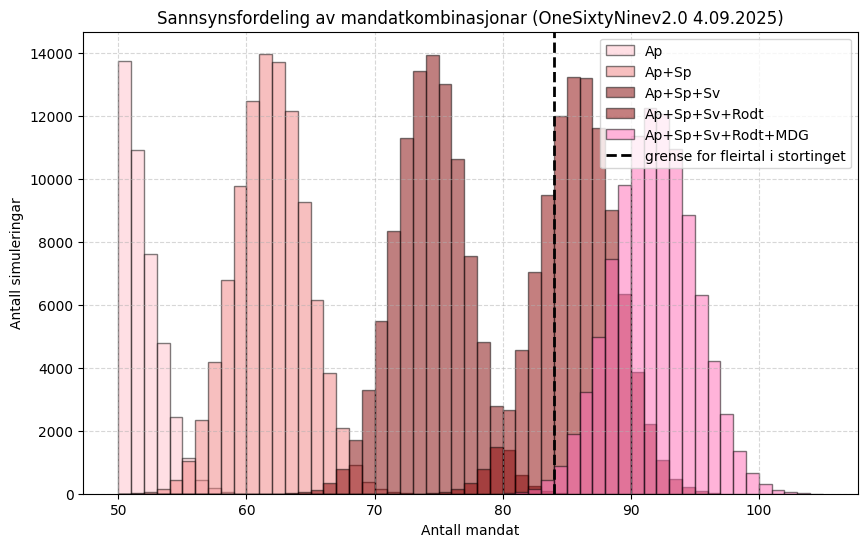

In [488]:
import matplotlib.pyplot as plt

# Define the combinations you want to plot
sample_169['Ap+Sp'] = sample_169['Ap'] + sample_169['SP']
sample_169['Ap+Sp+Sv'] = sample_169['Ap'] + sample_169['SP'] + sample_169['SV']
sample_169['Ap+Sp+Sv+Rodt'] = sample_169['Ap'] + sample_169['SP'] + sample_169['SV'] + sample_169['Rodt']
sample_169['Ap+Sp+Sv+MDG'] = sample_169['Ap'] + sample_169['SP'] + sample_169['SV'] + sample_169['MDG']
sample_169['Ap+Sp+Sv+Rodt+MDG'] = sample_169['Ap'] + sample_169['SP'] + sample_169['SV'] + sample_169['Rodt'] + sample_169['MDG']

# Put them in a dictionary for easy looping
cols_to_plot = {
    "Ap": "pink",
    "Ap+Sp": "lightcoral",
    "Ap+Sp+Sv": "maroon",
    "Ap+Sp+Sv+Rodt": "darkred",
    "Ap+Sp+Sv+Rodt+MDG": "hotpink"
    
}

# Plot histograms
plt.figure(figsize=(10,6))

for col, color in cols_to_plot.items():
    plt.hist(
        sample_169[col],
        bins=range(50, sample_169[col].max()),
        edgecolor='black',
        color=color,
        alpha=0.5,
        label=col
    )

# Vertical line for majority
plt.axvline(
    x=84,
    color='black',
    linestyle='--',
    linewidth=2,
    label='grense for fleirtal i stortinget'
)

plt.title('Sannsynsfordeling av mandatkombinasjonar (OneSixtyNinev2.0 4.09.2025)')
plt.xlabel('Antall mandat')
plt.ylabel('Antall simuleringar')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()



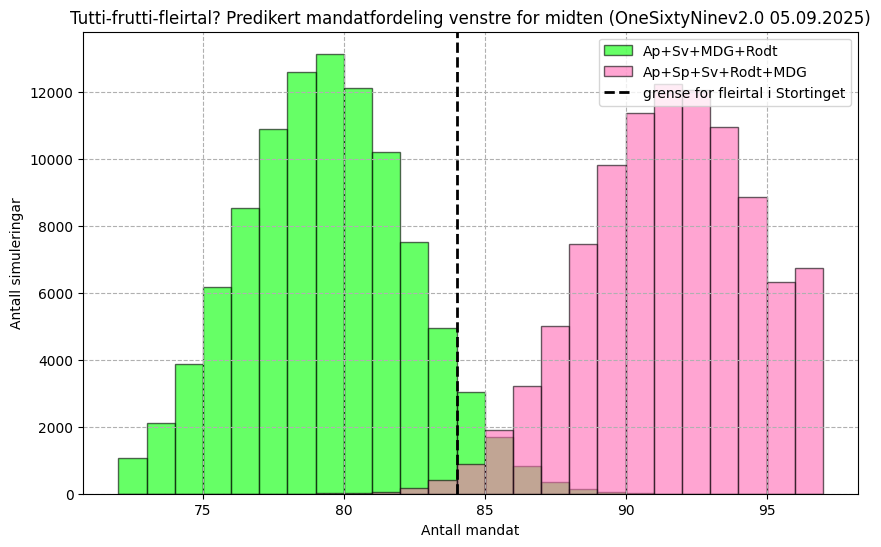

In [565]:
import matplotlib.pyplot as plt

# Define the combinations you want to plot
sample_169['Ap+Sp'] = sample_169['Ap'] + sample_169['SP']
sample_169['Ap+Sp+Sv'] = sample_169['Ap'] + sample_169['SP'] + sample_169['SV']
sample_169['Ap+Sp+Sv+Rodt'] = sample_169['Ap'] + sample_169['SP'] + sample_169['SV'] + sample_169['Rodt']
sample_169['Ap+Sp+Sv+MDG'] = sample_169['Ap'] + sample_169['SP'] + sample_169['SV'] + sample_169['MDG']
sample_169['Ap+Sv+MDG+Rodt'] = sample_169['Ap']+ sample_169['SV'] + sample_169['MDG'] + sample_169['Rodt'] 
sample_169['Ap+Sp+Sv+Rodt+MDG'] = sample_169['Ap'] + sample_169['SP'] + sample_169['SV'] + sample_169['Rodt'] + sample_169['MDG']

# Put them in a dictionary for easy looping
cols_to_plot = {
#    "Ap+Sp+Sv" : "palegoldenrod",
#    "Ap+Sp+Sv+MDG": "olivedrab",
    "Ap+Sv+MDG+Rodt": "lime",
#    "Ap+Sp+Sv+Rodt": "darkred",
    "Ap+Sp+Sv+Rodt+MDG": "hotpink"

}

# Plot histograms
plt.figure(figsize=(10,6))

for col, color in cols_to_plot.items():
    plt.hist(
        sample_169[col],
        bins=range(72, 98),
        edgecolor='black',
        color=color,
        alpha=0.6,
        label=col
    )

# Vertical line for majority
plt.axvline(
    x=84,
    color='black',
    linestyle='--',
    linewidth=2,
    label='grense for fleirtal i Stortinget'
)

plt.title('Tutti-frutti-fleirtal? Predikert mandatfordeling venstre for midten (OneSixtyNinev2.0 05.09.2025)')
plt.xlabel('Antall mandat')
plt.ylabel('Antall simuleringar')
plt.grid(True, linestyle='--', alpha=1)
plt.legend()
plt.show()



In [564]:
(sample_169['Ap+Sv+MDG+Rodt'] > 84).mean()

0.03077

In [490]:
filtered2 = sample_169[(sample_169['MDG'] < 3.9) & (sample_169['KrF'] > 4.1) & (sample_169['Venstre'] > 4.1)]

In [491]:
filtered2

Party,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Sum_adj,...,red_green_victory,ap_sp_victory,ap_sp_sv_victory,r_avh,g_avh,Ap+Sp,Ap+Sp+Sv,Ap+Sp+Sv+Rodt,Ap+Sp+Sv+MDG,Ap+Sp+Sv+Rodt+MDG
113,51,25,41,13,10,8,8,2,11,169,...,True,False,False,False,False,61,74,85,76,87
123,45,30,38,12,14,7,8,3,12,169,...,True,False,False,False,False,59,71,83,74,86
159,52,27,37,12,11,8,9,2,11,169,...,True,False,False,False,False,63,75,86,77,88
197,49,26,41,12,11,7,9,2,12,169,...,True,False,False,False,False,60,72,84,74,86
302,50,26,41,12,12,7,7,2,12,169,...,True,False,False,False,False,62,74,86,76,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99901,54,26,37,14,10,7,7,2,12,169,...,True,False,False,False,False,64,78,90,80,92
99910,51,29,40,11,11,7,7,2,11,169,...,True,False,False,False,False,62,73,84,75,86
99924,45,29,41,13,13,7,7,2,12,169,...,True,False,False,False,False,58,71,83,73,85
99926,52,26,38,13,13,7,8,2,10,169,...,True,False,False,False,False,65,78,88,80,90


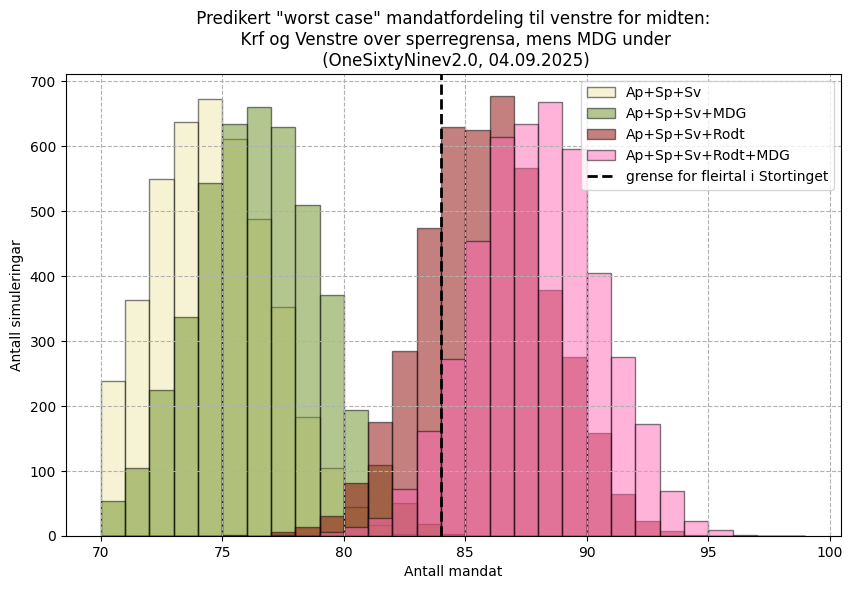

In [537]:
import matplotlib.pyplot as plt

# Put them in a dictionary for easy looping
cols_to_plot = {
    "Ap+Sp+Sv" : "palegoldenrod",
    "Ap+Sp+Sv+MDG": "olivedrab",
    "Ap+Sp+Sv+Rodt": "darkred",
    "Ap+Sp+Sv+Rodt+MDG": "hotpink"

}

# Plot histograms
plt.figure(figsize=(10,6))

for col, color in cols_to_plot.items():
    plt.hist(
        filtered2[col],
        bins=range(70, 100),
        edgecolor='black',
        color=color,
        alpha=0.5,
        label=col
    )

# Vertical line for majority
plt.axvline(
    x=84,
    color='black',
    linestyle='--',
    linewidth=2,
    label='grense for fleirtal i Stortinget'
)

plt.title(' Predikert "worst case" mandatfordeling til venstre for midten: \n  Krf og Venstre over sperregrensa, mens MDG under \n (OneSixtyNinev2.0, 04.09.2025)')
plt.xlabel('Antall mandat')
plt.ylabel('Antall simuleringar')
plt.grid(True, linestyle='--', alpha=0.99)
plt.legend()
plt.show()



In [559]:
filtered2.red_green_victory.mean()

0.8764521894548705

In [493]:
last_fact=df_orig[df_orig.index=='2025-08-31'][['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt']]

In [494]:
last_fact

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt
Mnd,,,,,,,,,
2025-08-31,27.3,15.3,21.2,6.3,6.2,4.6,4.2,4.3,6.1


In [495]:
last_mandate=pd.DataFrame(columns=last_fact.columns)

In [496]:
for party in last_fact.columns:
    last_mandate[party]=last_fact[party].apply(calc_mandat)

In [497]:
last_mandate

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt
Mnd,,,,,,,,,
2025-08-31,49,28,38,11,11,8,8,8,11


In [498]:
last_mandate['Sum']=last_mandate.sum(axis=1)

In [499]:
last_mandate

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Sum
Mnd,,,,,,,,,,
2025-08-31,49,28,38,11,11,8,8,8,11,172


In [500]:
forecast_df

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre
2025-09-30,26.996663,15.114282,21.640908,6.933171,6.890096,3.713249,4.475671,4.148694,6.378027,3.6226


In [501]:
forecast_df['Sum']=forecast_df.sum(axis=1)

In [502]:
forecast_df

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre,Sum
2025-09-30,26.996663,15.114282,21.640908,6.933171,6.890096,3.713249,4.475671,4.148694,6.378027,3.6226,99.913361


In [503]:
cov_matrix

array([[ 2.10852507e+00, -6.50120758e-01, -6.38359743e-01,
        -1.53473549e-01, -2.82182112e-01, -3.36321314e-02,
        -1.26072890e-01, -6.53910632e-02, -1.49468599e-01,
         9.15682749e-03],
       [-6.50120758e-01,  1.43010681e+00, -3.02364723e-01,
        -6.04077619e-02, -2.33099742e-01, -6.86666738e-02,
         2.19279951e-03, -7.79894294e-02, -1.72756167e-02,
        -9.26371648e-03],
       [-6.38359743e-01, -3.02364723e-01,  1.24704376e+00,
        -9.07860435e-03, -1.15189855e-01, -1.24713260e-02,
        -6.21346704e-02,  1.04659934e-02, -3.95399872e-02,
        -7.91716593e-02],
       [-1.53473549e-01, -6.04077619e-02, -9.07860435e-03,
         2.02923111e-01, -2.47073238e-02,  6.47622118e-03,
         2.25848218e-02,  1.90759674e-03,  6.95431560e-03,
         3.53384733e-03],
       [-2.82182112e-01, -2.33099742e-01, -1.15189855e-01,
        -2.47073238e-02,  7.85135622e-01, -4.59483090e-02,
        -3.82083510e-02, -1.19732396e-02,  5.31619789e-02,
        -7.

In [504]:
forecast

array([[-0.30333737, -0.18571784,  0.44090763,  0.63317091,  0.69009562,
        -0.88675065,  0.27567106, -0.15130579,  0.27802659, -0.87739951]])

In [505]:
import numpy as np
from scipy.optimize import minimize

# example: estimates
parties = [c for c in forecast_df.columns if c != "Sum"]
e = forecast_df.loc["2025-09-30", parties].values


# weight matrix (identity for simple case)
W = cov_matrix

def objective(p):
    diff = p - e
    return diff @ W @ diff  # quadratic form

cons = [{'type': 'eq', 'fun': lambda p: np.sum(p) - 100}]
bounds = [(0, None)] * len(e)

res = minimize(objective, e, constraints=cons, bounds=bounds)
p_adj = res.x
print(p_adj)

[27.00532655 15.12294608 21.64957156  6.94183486  6.89875956  3.72191329
  4.484335    4.15735815  6.38669053  3.63126443]


In [506]:
p_adj

array([27.00532655, 15.12294608, 21.64957156,  6.94183486,  6.89875956,
        3.72191329,  4.484335  ,  4.15735815,  6.38669053,  3.63126443])

In [507]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

data=sampled_df[['KrF', 'Venstre', 'MDG']]

# Step 1: Calculate individual probabilities
individual_probabilities = {col: (data[col] >= 4.0).mean() for col in data.columns}

# Step 2: Calculate joint probabilities for combinations of 1 to 5 columns
joint_probabilities = {}
for r in range(1, len(data)):  
    for combo in combinations(data.columns, r):
        joint_condition = np.all(data[list(combo)] >= 4.0, axis=1)
        joint_probabilities[combo] = joint_condition.mean()




In [508]:
individual_probabilities

{'KrF': 0.19839, 'Venstre': 0.88455, 'MDG': 0.67162}

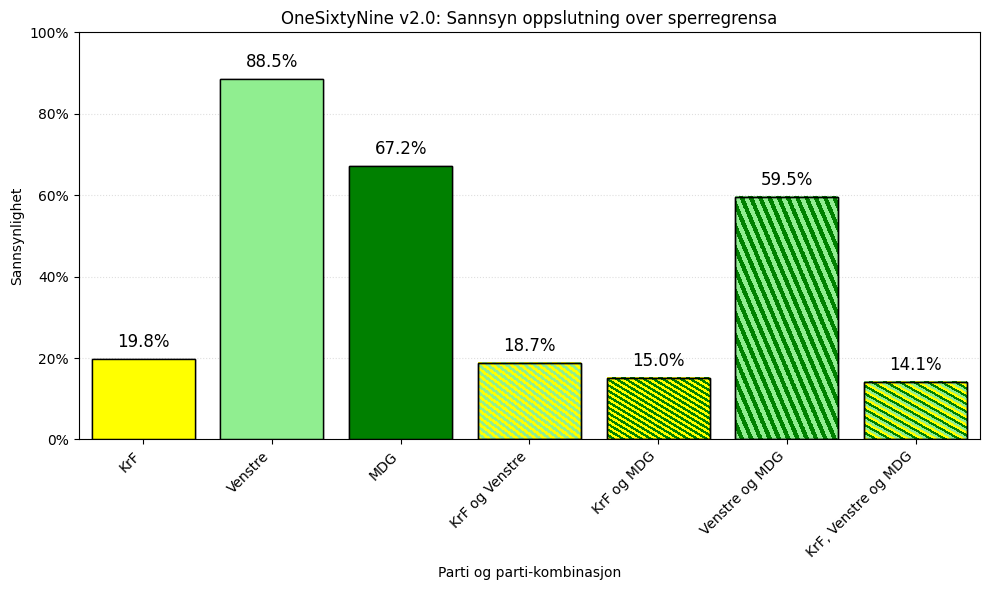

In [509]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import to_rgb
from matplotlib.ticker import PercentFormatter

def combo_to_label(combo):
    combo = [str(c) for c in combo]  # konverter til str
    if len(combo) == 1:
        return combo[0]
    elif len(combo) == 2:
        return f'{combo[0]} og {combo[1]}'
    else:
        return f"{', '.join(combo[:-1])} og {combo[-1]}"

# Partifarger
party_colors = {'KrF': 'yellow', 'Venstre': 'lightgreen', 'MDG': 'green'}
rgb = {k: np.array(to_rgb(v)) for k, v in party_colors.items()}

x = np.arange(len(joint_probabilities))
vals = list(joint_probabilities.values())

fig, ax = plt.subplots(figsize=(10, 6))

# Justerbar stripebredde og oppløsning
stripe_px = 18   # piksler pr. stripe (mindre=tunnere striper)
size = 400       # høyere verdi = glattere diagonaler

for i, (combo, value) in enumerate(joint_probabilities.items()):
    if len(combo) == 1:
        ax.bar(i, value, color=party_colors[combo[0]], edgecolor='black', width=0.8, zorder=2)
    else:
        # Lag høytoppløst diagonalt mønster i 45°
        h = w = size
        yy, xx = np.mgrid[0:h, 0:w]
        idx = ((xx + yy) // stripe_px) % len(combo)

        pattern = np.zeros((h, w, 3), dtype=float)
        for j, party in enumerate(combo):
            pattern[idx == j] = rgb[party]

        ax.imshow(pattern,
                  extent=(i - 0.4, i + 0.4, 0, value),
                  origin='lower',
                  aspect='auto',
                  interpolation='nearest',
                  zorder=2)

        # Kantlinje rundt stolpen
        ax.add_patch(Rectangle((i - 0.4, 0), 0.8, value,
                               fill=False, edgecolor='black', linewidth=1, zorder=3))

for i, (combo, value) in enumerate(joint_probabilities.items()):
    if len(combo) == 1:
        ax.bar(i, value, color=party_colors[combo[0]], edgecolor='black', width=0.8, zorder=2)
        # Legg til verdi oppå stolpen
        ax.text(i, value + 0.02, f'{value*100:.1f}%', ha='center', va='bottom', fontsize=12, zorder=4)
    else:
        # Lag høytoppløst diagonalt mønster i 45°
        h = w = size
        yy, xx = np.mgrid[0:h, 0:w]
        idx = ((xx + yy) // stripe_px) % len(combo)

        pattern = np.zeros((h, w, 3), dtype=float)
        for j, party in enumerate(combo):
            pattern[idx == j] = rgb[party]

        ax.imshow(pattern,
                  extent=(i - 0.4, i + 0.4, 0, value),
                  origin='lower',
                  aspect='auto',
                  interpolation='nearest',
                  zorder=2)

        ax.add_patch(Rectangle((i - 0.4, 0), 0.8, value,
                               fill=False, edgecolor='black', linewidth=1, zorder=3))
        
        # Legg til verdi oppå stolpen
        ax.text(i, value + 0.02, f'{value*100:.1f}%', ha='center', va='bottom', fontsize=12, zorder=4)

ax.set_xticks(x)
#ax.set_xticklabels([str(c) for c in joint_probabilities.keys()], rotation=45, ha='right')
# Bruk funksjonen når du setter x-ticks
ax.set_xticklabels([combo_to_label(c) for c in joint_probabilities.keys()],
                   rotation=45, ha='right')
ax.set_title('OneSixtyNine v2.0: Sannsyn oppslutning over sperregrensa')
ax.set_xlabel('Parti og parti-kombinasjon')
ax.set_ylabel('Sannsynlighet')

# Fiks y-aksen: 0–100 % med prosentformat
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.grid(axis='y', linestyle=':', alpha=0.4)
ax.set_xlim(-0.5, len(joint_probabilities) - 0.5)
plt.tight_layout()
plt.show()


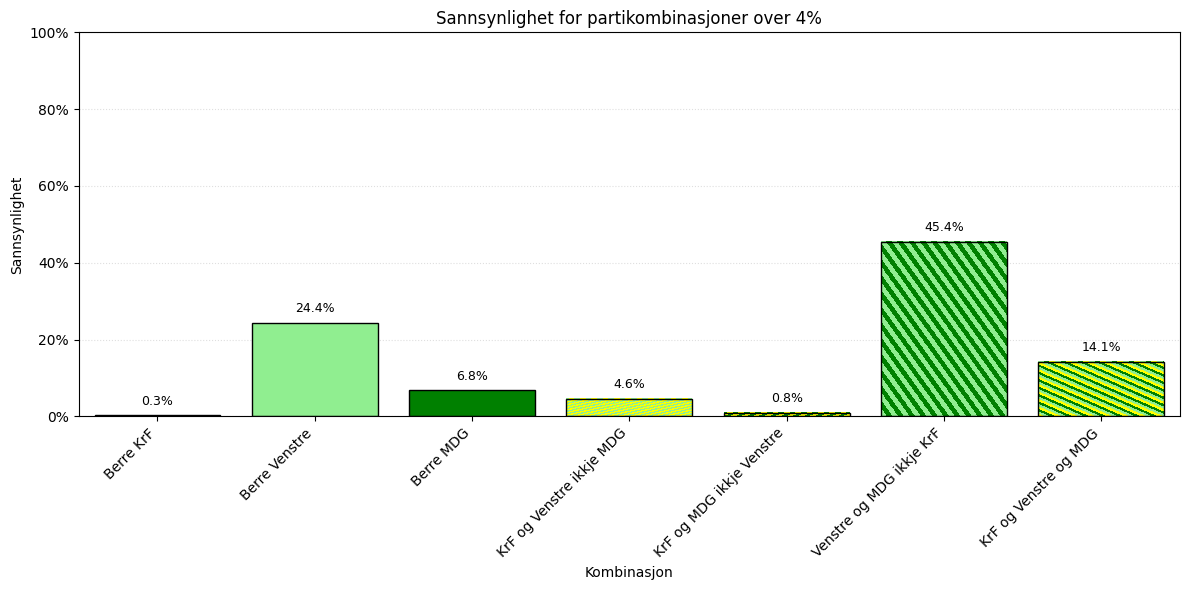

In [510]:
joint_probabilities = {}
cols = data.columns.tolist()
n = len(cols)

for r in range(1, n + 1):
    for combo in combinations(cols, r):
        must_have = list(combo)
        must_not_have = [c for c in cols if c not in combo]

        condition = np.all(data[must_have] >= 4.0, axis=1)
        if must_not_have:
            condition &= np.all(data[must_not_have] < 4.0, axis=1)

        joint_probabilities[combo] = condition.mean()

# --- Funksjon for pene x-etiketter ---
def combo_to_label(combo):
    others = [c for c in data.columns if c not in combo]
    if len(combo) == 1:
        if others:
            return f'Berre {combo[0]}'
        else:
            return combo[0]
    else:
        label = ' og '.join(combo)
        if others:
            label += ' ikkje ' + ', '.join(others)
        return label

# --- Farger for partier ---
party_colors = {'KrF': 'yellow', 'Venstre': 'lightgreen', 'MDG': 'green'}
rgb = {k: np.array(to_rgb(v)) for k, v in party_colors.items()}

# --- Plotting ---
x = np.arange(len(joint_probabilities))
vals = list(joint_probabilities.values())

fig, ax = plt.subplots(figsize=(12, 6))

stripe_px = 18
size = 400

for i, (combo, value) in enumerate(joint_probabilities.items()):
    if len(combo) == 1:
        ax.bar(i, value, color=party_colors[combo[0]], edgecolor='black', width=0.8, zorder=2)
        ax.text(i, value + 0.02, f'{value*100:.1f}%', ha='center', va='bottom', fontsize=9, zorder=4)
    else:
        h = w = size
        yy, xx = np.mgrid[0:h, 0:w]
        idx = ((xx + yy) // stripe_px) % len(combo)

        pattern = np.zeros((h, w, 3), dtype=float)
        for j, party in enumerate(combo):
            pattern[idx == j] = rgb[party]

        ax.imshow(pattern,
                  extent=(i - 0.4, i + 0.4, 0, value),
                  origin='lower',
                  aspect='auto',
                  interpolation='nearest',
                  zorder=2)

        ax.add_patch(Rectangle((i - 0.4, 0), 0.8, value,
                               fill=False, edgecolor='black', linewidth=1, zorder=3))
        ax.text(i, value + 0.02, f'{value*100:.1f}%', ha='center', va='bottom', fontsize=9, zorder=4)

# X-akse med pene etiketter
ax.set_xticks(x)
ax.set_xticklabels([combo_to_label(c) for c in joint_probabilities.keys()],
                   rotation=45, ha='right')

ax.set_title('Sannsynlighet for partikombinasjoner over 4%')
ax.set_xlabel('Kombinasjon')
ax.set_ylabel('Sannsynlighet')

ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.grid(axis='y', linestyle=':', alpha=0.4)

ax.set_xlim(-0.5, len(joint_probabilities) - 0.5)  # Sørg for at første og siste stolpe vises helt

plt.tight_layout()
plt.show()

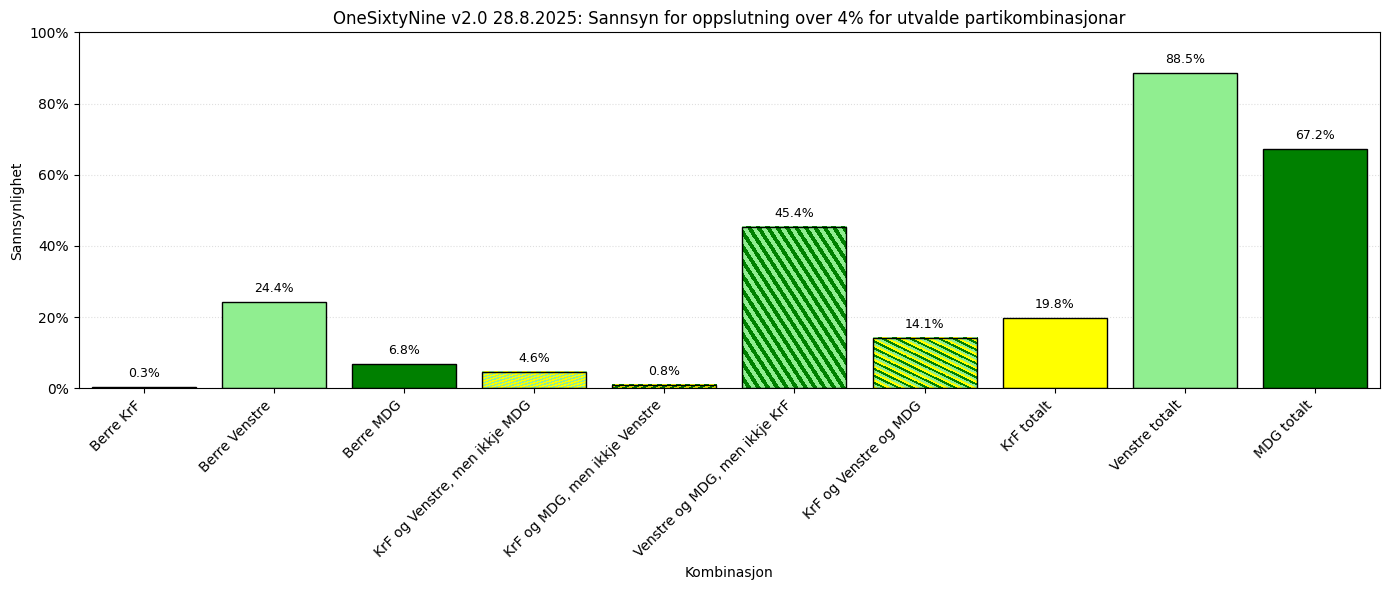

In [511]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import to_rgb
from matplotlib.ticker import PercentFormatter
from itertools import combinations

# --- Eksempeldata (bruk din sampled_df) ---
# sampled_df = pd.DataFrame({
#     'KrF': np.random.uniform(0, 10, 1000),
#     'Venstre': np.random.uniform(0, 10, 1000),
#     'MDG': np.random.uniform(0, 10, 1000)
# })

data = sampled_df[['KrF', 'Venstre', 'MDG']]

# --- Beregn joint probabilities med "bare / ikke" logikk ---
joint_probabilities = {}
cols = data.columns.tolist()
n = len(cols)

for r in range(1, n + 1):
    for combo in combinations(cols, r):
        must_have = list(combo)
        must_not_have = [c for c in cols if c not in combo]

        condition = np.all(data[must_have] >= 4.0, axis=1)
        if must_not_have:
            condition &= np.all(data[must_not_have] < 4.0, axis=1)

        joint_probabilities[combo] = condition.mean()

# --- Beregn totals for hver enkelt parti ---
total_probabilities = {col: (data[col] >= 4.0).mean() for col in data.columns}
for col, prob in total_probabilities.items():
    joint_probabilities[(col, 'totalt')] = prob

# --- Funksjon for pene x-etiketter ---
def combo_to_label(combo):
    # Håndter totals
    if combo[-1] == 'totalt':
        return f'{combo[0]} totalt'
    
    others = [c for c in data.columns if c not in combo]
    if len(combo) == 1:
        if others:
            return f'Berre {combo[0]}'
        else:
            return combo[0]
    else:
        label = ' og '.join(combo)
        if others:
            label += ', men ikkje ' + ', '.join(others)
        return label

# --- Farger for partier ---
party_colors = {'KrF': 'yellow', 'Venstre': 'lightgreen', 'MDG': 'green'}
rgb = {k: np.array(to_rgb(v)) for k, v in party_colors.items()}

# --- Plotting ---
x = np.arange(len(joint_probabilities))
vals = list(joint_probabilities.values())

fig, ax = plt.subplots(figsize=(14, 6))

stripe_px = 18
size = 400

for i, (combo, value) in enumerate(joint_probabilities.items()):
    # Totals kan vises med solid farge (velg første parti i tuple)
    if combo[-1] == 'totalt':
        ax.bar(i, value, color=party_colors[combo[0]], edgecolor='black', width=0.8, zorder=2)
        ax.text(i, value + 0.02, f'{value*100:.1f}%', ha='center', va='bottom', fontsize=9, zorder=4)
    elif len(combo) == 1:
        ax.bar(i, value, color=party_colors[combo[0]], edgecolor='black', width=0.8, zorder=2)
        ax.text(i, value + 0.02, f'{value*100:.1f}%', ha='center', va='bottom', fontsize=9, zorder=4)
    else:
        # Diagonalstripe for kombinasjoner
        h = w = size
        yy, xx = np.mgrid[0:h, 0:w]
        idx = ((xx + yy) // stripe_px) % len(combo)

        pattern = np.zeros((h, w, 3), dtype=float)
        for j, party in enumerate(combo):
            pattern[idx == j] = rgb[party]

        ax.imshow(pattern,
                  extent=(i - 0.4, i + 0.4, 0, value),
                  origin='lower',
                  aspect='auto',
                  interpolation='nearest',
                  zorder=2)

        ax.add_patch(Rectangle((i - 0.4, 0), 0.8, value,
                               fill=False, edgecolor='black', linewidth=1, zorder=3))
        ax.text(i, value + 0.02, f'{value*100:.1f}%', ha='center', va='bottom', fontsize=9, zorder=4)

# X-akse med pene etiketter
ax.set_xticks(x)
ax.set_xticklabels([combo_to_label(c) for c in joint_probabilities.keys()],
                   rotation=45, ha='right')

ax.set_title('OneSixtyNine v2.0 28.8.2025: Sannsyn for oppslutning over 4% for utvalde partikombinasjonar')
ax.set_xlabel('Kombinasjon')
ax.set_ylabel('Sannsynlighet')

ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.grid(axis='y', linestyle=':', alpha=0.4)

ax.set_xlim(-0.5, len(joint_probabilities) - 0.5)  # Sørg for at første og siste stolpe vises helt

plt.tight_layout()
plt.show()


In [548]:
import math
from scipy.stats import hypergeom

# Parametere
N = 3000000   # totalt antall kuler
K = 2996000  # antall grønne (suksesser i populasjonen)
n = 8000   # antall trekk
k = 8000 #antall suksess

p = hypergeom.pmf(k, N, K, n)
p


2.2815990829495048e-05

In [547]:
import math
from scipy.stats import hypergeom

# Parametere
N = 3000000   # totalt antall kuler
K = 2996000   # antall grønne
n = 8000        # antall trekk
k = 8000        # ønsker alle grønne

# --- Eksakt sannsynlighet (hypergeometrisk) ---
p_exact = hypergeom.pmf(k, N, K, n)

# --- Tilnærming (uavhengige trekk, binomial-aktig) ---
p_approx = (K / N) ** n

print(f"Eksakt hypergeom:   {p_exact:.6e}")
print(f"Tilnærming (K/N)^n: {p_approx:.6e}")
print(f"Forhold (approx/exact): {p_approx/p_exact:.3f}")


Eksakt hypergeom:   2.281599e-05
Tilnærming (K/N)^n: 2.314379e-05
Forhold (approx/exact): 1.014


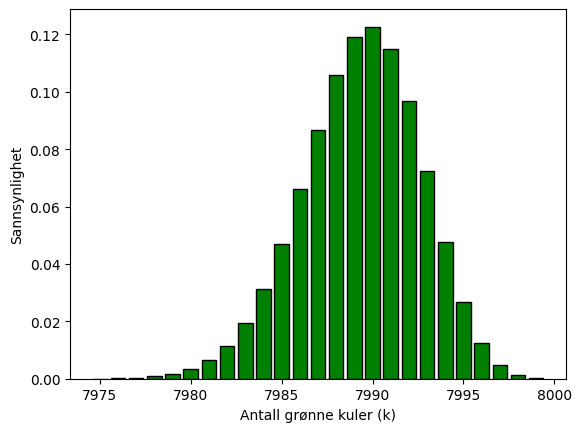

In [554]:
import math
import matplotlib.pyplot as plt
from scipy.stats import hypergeom

# Parametere
N = 3_000_000   # totalt antall kuler
K = 2_996_000   # antall grønne
n = 8000        # antall trekk

# Verdier av k vi vil se på (halen)
k_values = list(range(7975, 8000))

# Beregn sannsynlighetene
probs = [hypergeom.pmf(k, N, K, n) for k in k_values]

# Print ut verdiene
#for k, p in zip(k_values, probs):
#    print(f"P(X={k}) = {p:.6e}")

# Lag stolpediagram
plt.bar(k_values, probs, color="green", edgecolor="black")
plt.xlabel("Antall grønne kuler (k)")
plt.ylabel("Sannsynlighet")
plt.show()
